In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


加载并简单预览一下数据集

In [2]:
from mnist import MNIST
mndata = MNIST('/home/zhangj/Documents/ddpm/data/')
mndata.gz = True

images, labels = mndata.load_training()
images = np.array(images).reshape((-1, 28, 28)).astype(np.float32)


MNIST是一个28*28像素的黑白图像数据集；内容是 0~9 十种手写数字

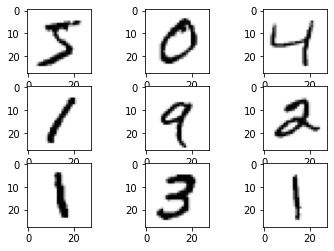

In [3]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    im = images[i].reshape((28, 28)).astype(np.float32)
    plt.imshow(im, cmap="Greys")
plt.show()


In [ ]:
# 定义滑动平均函数，使曲线“光滑”：
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# 加载Discriminator和Generator的Loss:
loss = np.loadtxt("../results/losses.log")

# 画图：
plt.plot(moving_average(loss[:, 0], 5), c="b")  # Discriminator
plt.plot(moving_average(loss[:, 1], 5), c="r")  # Generator
plt.show()


我们加载并可视化GAN训练的中间结果；
注意：需要把网络输出（-1到1之间的浮点数）转化成像素数值（0~255的整数）

In [5]:
# ### 加载自行训练的结果
# raw_images = np.load("../results/images.npy")
# t_list = [1,2,4,6,8,10]

# 我们也可以加载预先训练的结果：
raw_images = np.load("../results/images_opt.npy")
t_list = [1, 100, 200, 300, 400, 500]


In [6]:
images = (raw_images*255+255)/2.
print(images.shape)
print(images.min(), images.max())


(500, 50, 28, 28)
0.0 255.0


我们分别画出不同训练步数时，用固定噪音作为输入时，GAN的输出分别是什么

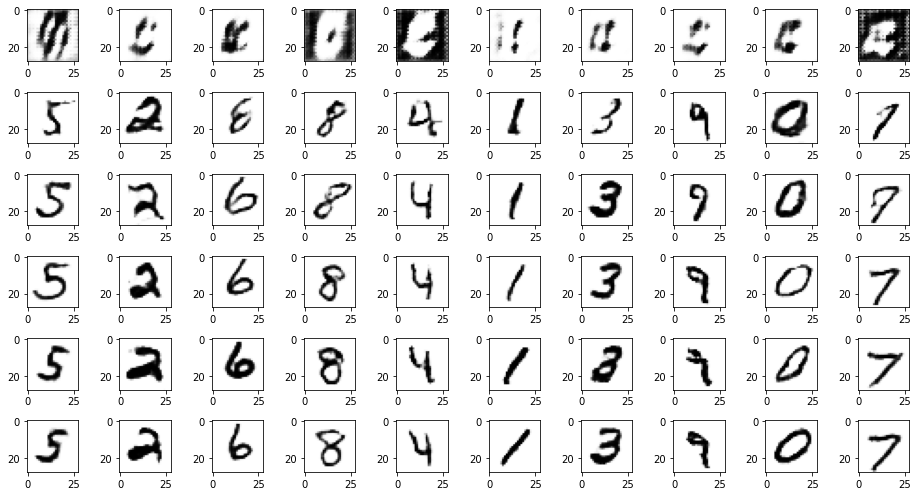

In [7]:
num_t = len(t_list)
num_digit = 10

plt.figure(figsize=(13, 7))
for i in range(num_digit):
    for t in range(num_t):
        images_ = images[t_list[t]-1]
        plt.subplot(num_t, num_digit, t*num_digit+i+1)
        im = images_[i*5+1].astype(np.int32).reshape((28, 28))
        plt.imshow(im, cmap="Greys")
plt.tight_layout()
plt.show()


我们可以加载训练最终得到的生成器的checkpoint，并用它来产生不同的随机样本（手写数字图像）

In [8]:
import mindspore.numpy as mnp
from mindspore import nn
from mindspore import Tensor
from mindspore import load_checkpoint, load_param_into_net
from mindspore import context

from model import Generator, Discriminator, WithLossCellG

context.set_context(mode=context.PYNATIVE_MODE)  # Generation

batchsize = 16
random_dim = 50

netG = Generator(input_dim=random_dim)
netD = Discriminator()
netG_with_criterion = WithLossCellG(netD, netG, info_wt=1.0)
netG_with_criterion.set_train(False)

# 使用预先训练的模型：
param_dict = load_checkpoint(
    "../ckpts/opt_ckpts/" + "generator_epoch_50000.ckpt")

load_param_into_net(netG, param_dict)


[WARNING] ME(613204:139696436946752,MainProcess):2022-07-28-16:29:47.908.952 [mindspore/train/serialization.py:627] For 'load_param_into_net', remove parameter myTrainOneStepCellForG.netG.transform_input.0.weight's prefix name: myTrainOneStepCellForG., continue to load it to net parameter netG.transform_input.0.weight.
[WARNING] ME(613204:139696436946752,MainProcess):2022-07-28-16:29:47.910.523 [mindspore/train/serialization.py:627] For 'load_param_into_net', remove parameter myTrainOneStepCellForG.network.netG.transform_input.1.moving_mean's prefix name: myTrainOneStepCellForG.network., continue to load it to net parameter netG.transform_input.1.moving_mean.


[]

In [9]:
# 采样随机数，用于产生图像:
fixed_noise_int = Tensor(np.repeat(np.arange(10), batchsize), mnp.int32)
int_z = nn.OneHot(axis=-1, depth=10)(fixed_noise_int).astype(mnp.float32)

np.random.seed(888)
random_z = Tensor(np.random.randn(batchsize*10, random_dim-10), mnp.float32)
z = mnp.concatenate((random_z, int_z), -1)


In [10]:
# 根据随机数，产生新的随机图像:
img = netG(z)


In [11]:
# 定义一些画图所用的helper functions:

def post_process_images(images, digit_order=None):
    # images: (B,1,C);
    images = np.squeeze(images.asnumpy(), 1)
    images = (images*255+255)/2.  # rescaled to 0~255
    images = images.astype(np.int32)
    images = np.reshape(images, (10, batchsize, 28, 28))
    if digit_order is not None:
        images = images[digit_order]
    return images


def plot_fn(images, num_row=5, num_digit=10):
    # plt.figure(figsize=(13,6))
    plt.figure(figsize=(2*(num_row+0.5)+0.5, num_row+1))
    for i in range(num_digit):
        for t in range(num_row):
            _images = images[i]
            plt.subplot(num_row, num_digit, t*num_digit+i+1)
            im = _images[t].astype(np.int32).reshape((28, 28))
            plt.imshow(im, cmap="Greys")
    plt.tight_layout()
    plt.show()


(10, 16, 28, 28)


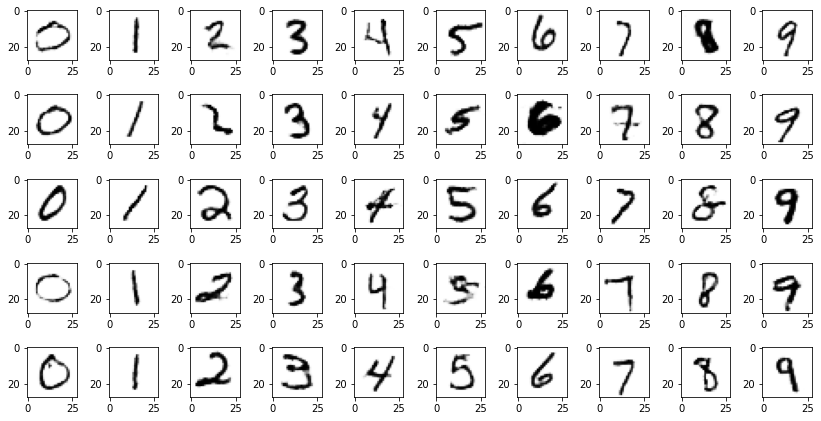

In [12]:
images = post_process_images(img, digit_order=[8, 5, 1, 6, 4, 0, 2, 9, 3, 7])
print(images.shape)  # (数字类别，样本数，长，宽)

plot_fn(images, num_row=5)
